##### **Tinkercademy note:**

This notebook is adapted (albeit heavily) from the work of [Trenton McKinney][1]. The full, original notebook can be found [here][2].


  [1]: https://trenton3983.github.io/
  [2]: https://github.com/trenton3983/DataCamp/blob/master/2019-07-19_fraud_detection_python.ipynb

# Introduction to Fraud Detection in Python

Organizations around the world [lose an estimated 5% of their annual revenues to fraud][1], according to a survey of Certified Fraud Examiners (CFEs). This notebook explores ways to use Python machine learning models  to help detect fraud in financial datasets.

Fraud can come in many forms:

* Insurance fraud
* Credit card fraud
* Identity theft
* Money laundering
* Tax evasion

Yet, detecting fraud is challenging because it is so uncommon (usually less than 0.01% of all transactions) and perpetrators often attempt to cover up their misdoings. Current options to detect fraud include:
* Reference checking - using flagged lists of criminals from authorities and comparing against the customer list
* Rule-based systems - these simply follow a pre-programmed script to classify transactions using manually set thresholds.
    * Might block transactions from specific postal codes/locations, from cards used too frequently.
    * Will catch fraud, but also will generate many false alarms.
    * While simple to set up, they are also inflexible and won't adapt without manual change.
    * Does not provide a confidence level of predictions (ML models will give a confidence score)

* Supervised learning ML algorithms
    * We provide a training dataset of known fraud cases to teach the model what features fraud cases tend to exhibit.

* Unsupervised learning ML algorithms
    * Without any labeled data (i.e. a training dataset), these algorithms try to identify unusual outliers in the dataset that may represent fraudulent transactions.
    * Abnormal behaviour doesn't guarantee fraud, so these often need human review.

  [1]: https://www.acfe.com/about-the-acfe/newsroom-for-media/press-releases/press-release-detail?s=ACFE-Estimates-Organizations-Lose-5-percent-to-Fraud

**Working with Google Colaboratory**

We are currently using **Google Colaboratory** to view a **Jupyter Notebook**. These notebooks can contain both text and Python code - which is invaluable for explaining or presenting code and/or analysis. You might notice the notebook is separated into cells. Each cell contains either text or Python code. To run a cell (i.e. execute Python code), you can select the cell and press **Shift + Enter**. You can also click the "**Play**" button that appears on the lefthand side of the cell when your mouse hovers over it.

For today, you (thankfully!) don't have to worry about any of the Python code. We'll explain what it does as we go through the steps - this notebook also contains written explanations of each step along the way as well. You might recognise some of the steps and metrics from our previous explorations as well! But the overall goal of this notebook is to showcase another way to utlise artificial intelligence to automate a difficult, time-consuming, and costly task: **fraud detection**.

**Imports**

We start by importing the libraries we will use during our analysis. We also define two custom functions that will later be used to prep and plot our data.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
from pathlib import Path
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

# Define a function to prep our data
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df.iloc[:, 2:30].values
    y = df.Class.values
    return X, y

# Define a function to create a scatter plot of our data and labels
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

**File Names**

We also set our filenames and store them in variables. By declaring these at the top of our notebook, we can easily run the same analysis on new dat sets simply by updating the names.

In [1]:
cc_file1 = 'https://raw.githubusercontent.com/iamamangosteen/aimlrpa/main/credit_card_fraud_txs.csv'
cc_file2 = 'https://raw.githubusercontent.com/iamamangosteen/aimlrpa/main/credit_card_fraud_txs2.csv'
banktxs = 'https://raw.githubusercontent.com/iamamangosteen/aimlrpa/main/bank_txs.csv'

**Pandas Configuration Options**

In [ ]:
#pd.set_option('display.max_columns', 700)
#pd.set_option('display.max_rows', 400)
#pd.set_option('display.min_rows', 10)
#pd.set_option('display.expand_frame_repr', True)

# Preparing your data

### Familiarising Ourself With the Dataset

We'll be working with `creditcard_sampledata.csv`, a dataset containing credit card transaction data. Whenever working with a new dataset, a good first step is to familiarise yourself with the data set:

*   Our dataset has 5000 rows of data.
*   Each row represents a transaction - there are 28 columns of anonymous variables (labeled Variable01 to Variable28).
*   These represent things like: time of day, location, etc.
*   Each row also has a column containing the Transaction Amount and a Class: 0 means the transaction was not fraudulent while 1 means the transaction was fraudulent.

In [ ]:
#import the file into a dataframe, i.e. a "spreadsheet" in Python
df = pd.read_csv(cc_file1)

In [ ]:
df

,Variable01,Variable02,Variable03,Variable04,Variable05,Variable06,Variable07,Variable08,Variable09,Variable10,...,Variable21,Variable22,Variable23,Variable24,Variable25,Variable26,Variable27,Variable28,Amount,Class
0,1.74,-1.38,-1.05,-0.39,-1.15,-1.10,-0.95,-0.02,-0.03,0.23,...,0.35,0.89,0.03,0.42,-0.42,-0.17,-0.01,0.01,215.46,0
1,0.70,-1.82,0.56,-0.28,-1.75,0.12,-0.48,0.13,-0.67,0.47,...,0.11,-0.26,-0.13,0.24,0.07,-0.45,-0.02,0.07,324.63,0
2,0.85,-0.76,0.99,0.21,-1.24,0.06,-0.60,0.28,1.24,-0.45,...,-0.17,-0.40,0.08,0.12,0.00,0.79,-0.04,0.02,56.38,0
3,0.11,0.79,-2.01,-1.85,3.47,2.89,0.35,0.92,-0.18,-0.79,...,-0.28,-0.72,0.12,0.51,-0.45,0.18,0.25,0.08,0.78,0
4,1.13,0.28,0.19,1.02,-0.13,-0.63,0.10,-0.15,0.14,0.03,...,0.03,0.13,-0.15,-0.17,0.72,-0.27,0.02,0.02,7.05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.22,1.99,-3.68,4.63,0.07,-0.92,-2.06,0.43,-1.81,-2.65,...,0.34,-0.15,-0.02,-0.31,0.23,0.11,0.57,0.22,1.03,1
4996,-1.79,1.95,-2.81,0.10,-0.20,0.24,-3.06,-2.20,-0.64,-5.38,...,-0.08,0.58,-0.08,-0.50,0.33,-0.59,0.14,0.03,44.50,1
4997,-7.64,3.27,-7.37,5.16,-4.54,-1.76,-6.49,3.44,-3.63,-6.26,...,1.49,-0.01,-0.80,0.37,-1.12,-0.61,-0.83,0.43,87.66,1
4998,-1.19,1.73,-2.57,5.25,-0.33,1.46,0.71,-0.14,-2.11,-0.42,...,-0.44,-0.77,0.41,-0.08,-0.52,0.01,-0.23,-0.84,363.54,1


In [ ]:
# Count the occurrences of fraud and no fraud and print them
occ = df['Class'].value_counts()
print("Number of legitimate transactions:", occ[0])
print("Number of fraudulent transactions:", occ[1])

Number of legitimate transactions: 4950
Number of fraudulent transactions: 50


In [ ]:
# Print the ratio of fraud cases
ratio_cases = occ/len(df.index)
print(f'Percent of fraudulent cases: {round(ratio_cases[1]*100,2)}')
print(f'Percent of non-fraudulent cases: {round(ratio_cases[0]*100,2)}')

Percent of fraudulent cases: 1.0
Percent of non-fraudulent cases: 99.0


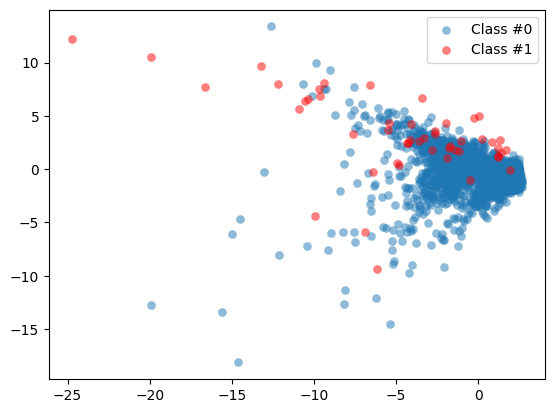

In [ ]:
# Plot our data
plt.scatter(df.Variable01[df.Class == 0], df.Variable02[df.Class == 0], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(df.Variable01[df.Class == 1], df.Variable02[df.Class == 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
plt.legend()
plt.show()

You might notice right away that fraud cases are a very tiny minority (50 cases of fraud out of 5000 total cases). The visualisation quickly confirms this, and serves as a great way to convey our results to others. However, with our knowledge of machine learning bias, we know we need training classes of roughly equivalent size. So the very first thing we need to fix is this imbalance.

## Data Resampling

Resampling can help model performance in cases of imbalanced data sets. Note that you should only ever resample your **training** dataset, not your **test** dataset. There are multiple ways to perform resampling:
* Undersampling - reducing the size of the majority class down to the size of the minority class
* Oversampling - duplicating the minority class until it's the same size as the majority class
* SMOTE (Synthetic Minority Oversampling Technique) - a method of generating more data points for the minority class without duplicating. Instead, it attempts to identify common features and generates similar "synthetic" data points.

![oversampling and undersampling](https://raw.githubusercontent.com/iamamangosteen/aimlrpa/main/resampling.png)

Disadvantages:
* with undersampling, a lot of information is thrown away
* with oversampling, the model will be trained on a lot of duplicates

![SMOTE](https://github.com/iamamangosteen/aimlrpa/blob/main/smote.png?raw=true)

Disadvantages:
* with SMOTE, we are assuming all fraud cases have similar, distinct features, which may not always be true. Thus, at it's worst, it can make it harder for the model to detect actual fraud.

### Using Synthetic Minority Oversampling Technique (SMOTE)

For this analysis, we'll use SMOTE on our dataset to balance our classes. Remember, SMOTE does not create exact copies of observations, but rather **creates new, synthetic, samples** that are quite similar to the existing observations in the minority class.

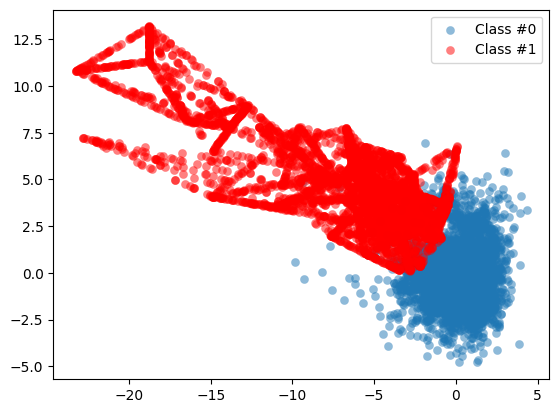

In [ ]:
# Run the prep_data function
X, y = prep_data(df)

# Define the resampling method
method = SMOTE()

# Create the resampled feature set
X_resampled, y_resampled = method.fit_resample(X, y)

# Plot the resampled data
plot_data(X_resampled, y_resampled)

You can see now the minority class has **many** more observations. We can confirm this by counting the number of observations before and after SMOTE:

In [ ]:
# Count the occurrences of fraud and no fraud in the original dataset
newocc = pd.value_counts(pd.Series(y))
print("Number of legitimate transactions (original dataset):", newocc[0])
print("Number of fraudulent transactions (original dataset):", newocc[1])

Number of legitimate transactions (original dataset): 4950
Number of fraudulent transactions (original dataset): 50


In [ ]:
# Count the occurrences of fraud and no fraud in our newly modified dataset
newocc = pd.value_counts(pd.Series(y_resampled))
print("Number of legitimate transactions (after SMOTE):", newocc[0])
print("Number of fraudulent transactions (after SMOTE):", newocc[1])

Number of legitimate transactions (after SMOTE): 4950
Number of fraudulent transactions (after SMOTE): 4950


# Exploring the traditional method of fraud detection

Let's first try to detect fraud using the old rule-based method. We'll take a look at the statistical means of fraud and non-fraud cases in our dataset. We'll then use the differences in those values to determine thresholds with which we will use to detect fraud.





**Instructions**

* Use `groupby()` to group `df` on `Class` and obtain the mean of the features.
* Create the condition `V1` smaller than -3, and `V3` smaller than -5 as a condition to flag fraud cases.
* As a measure of performance, use the `crosstab` function from `pandas` to compare our flagged fraud cases to actual fraud cases.

In [ ]:
#Print out the mean values for each feature for non-fraud cases (0) and fraud cases (1)
df.groupby('Class').mean()

,Variable01,Variable02,Variable03,Variable04,Variable05,Variable06,Variable07,Variable08,Variable09,Variable10,...,Variable20,Variable21,Variable22,Variable23,Variable24,Variable25,Variable26,Variable27,Variable28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,0.037711,0.014903,0.043897,-0.044347,-0.014541,-0.034978,0.017602,-0.014236,-0.004202,0.005238,...,-0.005354,-0.006895,-0.012329,-0.002511,-0.000689,-0.001198,-0.006487,-0.010788,0.002968,85.878788
1,-4.956800,3.251400,-7.075400,4.760000,-3.254800,-1.587800,-5.749000,1.384800,-2.521200,-5.850600,...,0.191000,0.671200,0.101600,-0.059000,-0.026000,-0.065000,-0.020400,0.387400,0.016600,112.472600


* Notice how there's quite a wide variation in the means of some features?
* Let's use features V1 and V3 as an example.
* We'll set a rule that if feature V1 is less than -3 and feature V3 is less than -5, we will classify the transaction as fraudulent.
* We'll then print out a confusion matrix to view the results. Let's see how well it performs:

In [ ]:
df['flag_as_fraud'] = np.where(np.logical_and(df.Variable01 < -3, df.Variable03 < -5), 1, 0)

pd.crosstab(df.Class, df.flag_as_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud'])

Flagged Fraud,0,1
Actual Fraud,,
0,4934,16
1,30,20


**With this rule, 20 out of 50 fraud cases are detected, 30 are not detected, and 16 false positives are identified.**

You can try out other rules yourself by modifying the below code, for example:
* `df.Variable04 > 4` sets a rule that requires feature Variable04 to be greater than 4
* `df.Variable07 < -4` sets a rule that requires feature Variable07 to be less than -4

In [ ]:
df['flag_as_fraud'] = np.where(np.logical_and(df.Variable04 > 4, df.Variable07 < -4), 1, 0)

In [ ]:
pd.crosstab(df.Class, df.flag_as_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud'])

Flagged Fraud,0,1
Actual Fraud,,
0,4948,2
1,31,19


**With this alternative rule, 19 out of 50 fraud cases are detected, 31 are not detected, and 2 false positives are identified.**

**Decision Trees**

What we've done here is essentially create a very simple decision tree. (i.e. if Variable04 is greater than 4 AND Variable07 is less than -4 then flag as fraud, otherwise do not flag as fraud)

![decision tree](https://raw.githubusercontent.com/iamamangosteen/aimlrpa/main/decisiontree-fraud.png)

* Commonly used for fraud detection
* Easily interpreted by analysts and the public at large
* However, decision trees are prone to overfit the data, meaning they often will not do as well a job at catching future occurrences of fraud.

### Using ML classification to catch fraud

Do you think we can beat those results? Next we'll implement a simple **Logistic Regression** machine learning model on our credit card data instead.

**Steps:**

* Split `X` and `y` into training and test datasets, using 80% for training while keeping 20% of the data for testing.
* Fit a model to the training data.
* Use the model to predict classes of the test dataset (i.e. is each row fraudulent or not) by running `model.predict` on `X_test`.
* Compare the results stored in `predicted` with the actual classes stored in  `y_test` and use the resulting confusion matrix to check how well your model performed.

In [ ]:
# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Fit a logistic regression model to our data
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# Obtain model predictions
predicted = model.predict(X_test)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       990
           1       1.00      0.90      0.95        10

    accuracy                           1.00      1000
   macro avg       1.00      0.95      0.97      1000
weighted avg       1.00      1.00      1.00      1000

Confusion matrix:
 [[990   0]
 [  1   9]]


We are now getting far fewer false positives and also catching a higher percentage of fraud cases, so it looks like a clear improvement.

NOTE: Remember we are using only our test data to calculate the model results on, which is 20% of our dataset. So that's why our confusion matrix only has 1000 data points rather than the full 5000.

### Logistic regression with SMOTE

Let's try the same exact analysis, except now let's use our **SMOTE** resampling method to even out the sizes of our classes.

**Instructions**

* Choose the resampling model (in this case we're using `BorderlineSMOTE`)
* Choose the regression model (in this case we're performing `LogisticRegression`)
* Pass both of the above into a pipeline, which can be treated as a **single machine learning model**
* Now perform the same steps as above: split into training and test datasets, fit a model, use the model to predict, and then compare the predicted classes to the actual classes.

In [ ]:
# Define which resampling method and which ML model to use in the pipeline
resampling = BorderlineSMOTE()
model = LogisticRegression(solver='liblinear')

pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

pipeline.fit(X_train, y_train)
predicted = pipeline.predict(X_test)

# Obtain the results from the classification report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       990
           1       1.00      1.00      1.00        10

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Confusion matrix:
 [[990   0]
 [  0  10]]


As you can see, the SMOTE slightly improves our results. We now manage to find all cases of fraud with no false positives. It's important to note resampling doesn't necessarily lead to better results. If fraud cases are very spread and scattered over the data, using SMOTE can introduce some bias. It will create nearest neighbors samples and label them as fraud, but they aren't necessarily also fraud cases, so the fake samples might confuse the model more than if we did not use resampling.

<hr>

# Fraud detection with Random Forests
Previously we took a look at simple decision trees, which were a traditonal method to detect fraud. They are often better than nothing, but have downsides such as overfitting.

Let's now look at a more advanced method that utilises multiple decision trees: **Random Forests**. These commprise of many decision trees, each of which decides whether or not a model should be labeled as fraud. Then, the Random Forest model will output a single classification besed on majority rule. Compared to an individual decision tree, random forests do not have the same overfitting concerns.

![random forest](https://raw.githubusercontent.com/iamamangosteen/aimlrpa/main/randomforests.png)

### Natural Accuracy

To generate a baseline model let's first calculate the **natural accuracy**, i.e. what would our accuracy be if we predicted every transaction as non-fraudulent. This is the accuracy that our model must improve on, otherwise our model isn't an improvement over doing nothing at all!

**Steps**

* Count the total number of observations in the dataset.
* Count the non-fraudulent cases in our dataset.
* Calculate the natural accuracy by dividing the non-fraudulent cases over the total observations.

We previously did this for our first dataset, but we'll be using a new dataset here, so let's run through the steps again:

In [ ]:
df2 = pd.read_csv(cc_file2)
X, y = prep_data(df2)
df2.Class.value_counts()

0    6700
1     300
Name: Class, dtype: int64

In [ ]:
# Count the total number of observations from the length of y
total_obs = len(y)

# Count the total number of non-fraudulent observations
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

percentage = count_non_fraud/total_obs * 100
print(f'Accuracy: {percentage:0.2f}%')

Accuracy: 95.71%


**This tells us that by simply predicting that all cases are not fraud, we would be correct in 99.0% of the cases. So if we get an accuracy of less than this number, our model does not actually add any value in predicting how many cases are correct. Let's see how a random forest does in predicting fraud in our data.**

### **Random Forest Classifier**

Just like before, let's start by splitting the data into test and training datasets and defining the Random Forest model before fitting and testing the model.

**Steps**

* Split the dataset into training and test datasets.
* Assign the random forest classifier to `model`. Setting `n_estimators=20` means that we build 20 decisions trees before taking the mode as the prediction.
* Fit the model.
* Use the model to generate predictions, then compare with actual classes to see how well the model performed.

(Hopefully these steps are starting to look familiar! They're basically the same steps each time, just using different models.)

In [ ]:
# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define the model as the random forest
model = RandomForestClassifier(random_state=0, n_estimators=20)

# Fit the model to our training set
model.fit(X_train, y_train)

# Obtain predictions from the test data
predicted = model.predict(X_test)

print(f'Accuracy Score:\n{accuracy_score(y_test, predicted):0.3f}')

Accuracy Score:
1.000


## Evaluating Performance

What are some of the metrics we might use to evaluate our models? As mentioned before, simple accuracy is often not the best!

* **Accuracy**: total number of successful positive and negative predictions
* **Precision**: number of positive cases accurately predicted, i.e. out of all the patients that the model predicted as having diabetes, how many are actually diabetic?
* **Recall**: number of predicted positive cases that are actually positive, i.e. among those who are actually positive, how many did the model identify?

![accuracy precision recall](https://raw.githubusercontent.com/iamamangosteen/aimlrpa/main/accuracy-precision-recall.png)

* **F-Score**: takes both precision and recall into account to try and balance both.
\begin{align}
F-score = \frac{2\times{Precision}\times{Recall}}{Precision\times{Recall}} \\
\end{align}

* **Receiver Operating Characteristic (ROC) curve**: shows the true positive rate against the false positive rate at various threshold settings.

<img src="https://raw.githubusercontent.com/iamamangosteen/aimlrpa/main/roc-curve.png"  width="400" height="400">

* **Confusion Matrices**: we've been using these throughout to get a quick glance at the model's performance.

In [ ]:
# Obtain the predictions from our random forest model
predicted = model.predict(X_test)

# Predict probabilities
probs = model.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print('ROC Score:')
print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, predicted))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predicted))

ROC Score:
0.9999970474300831

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2016
           1       0.99      1.00      0.99        84

    accuracy                           1.00      2100
   macro avg       0.99      1.00      1.00      2100
weighted avg       1.00      1.00      1.00      2100


Confusion Matrix:
[[2015    1]
 [   0   84]]


Which metric you optimise will differ depending on your goals. For example, a credit card company wants to optimize for recall to catch as much fraud as possible because it's easy to block transactions, but very costly if a fradulent one gets through. An insurance company wants to optimize for precision to minimise false alarms due to the cost of investigating each case.

<hr>

## Parameter optimization with GridSearchCV

Now that we can measure performance, how can we improve our model? Typically, this involves tweaking the many parameters involved throughout the process. For example, our Random Forest model has all these paramters we can manually adjust:
```
model = RandomForestClassifier(n_estimators=10,
                               criterion=’gini’,
                               max_depth=None,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               max_features=’auto’,
                               n_jobs=-1, class_weight=None)
```
It's certainly possible to manually tweak these parameters, but you can also use Python to identify the best tweaks to make to improve your model by using `GridSearchCV`.

With `GridSearchCV` you define which performance metric to measure, and it will automatically tweak your parameters to optimise that metric. In this example, we'll optimise for Recall as we're interested in catching as many fraud cases as possible.

**Steps**

* Define in the parameter grid what parameters to test. Here we want to test:
    * between 1 and 30 trees
    * both `auto` and `log2` for max_features
    * four different maximum depths
    * both the `gini` and `entropy` split criterion
* Define the model
* Pass the model and the parameter grid into GridSearchCV and optimise for `recall`
* Fit the model and it will output the best parameters to optimise `recall`

In [ ]:
# Define the parameter sets to test
param_grid = {'n_estimators': [1, 30],
              'max_features': ['auto', 'log2'],
              'max_depth': [4, 8, 10, 12],
              'criterion': ['gini', 'entropy']}

# Define the model to use
model = RandomForestClassifier(random_state=4)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 1}

We've determined the best parameters to optimise recall for our model are criterion set to `gini`, max_depth set to `4`, max_features set to `auto`, and n_estimators set to `1`. We can then test these new parameters by training a new model. We'll start by defining a function to get the model results, and then test the parameters:

In [ ]:
def get_model_results(X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray, model):

    # Fit your training model to your training set
    model.fit(X_train, y_train)

    # Obtain the predicted values and probabilities from the model
    predicted = model.predict(X_test)

    try:
        probs = model.predict_proba(X_test)
        print('ROC Score:')
        print(roc_auc_score(y_test, probs[:,1]))
    except AttributeError:
        pass

    # Print the ROC curve, classification report and confusion matrix
    print('\nClassification Report:')
    print(classification_report(y_test, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, predicted))

In [ ]:
# Input the optimal parameters in the model
model = RandomForestClassifier(class_weight={0:1,1:12},
                               criterion='gini',
                               max_depth=4,
                               max_features='auto',
                               min_samples_leaf=10,
                               n_estimators=1,
                               n_jobs=-1,
                               random_state=4)

# Get results from your model
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2016
           1       1.00      1.00      1.00        84

    accuracy                           1.00      2100
   macro avg       1.00      1.00      1.00      2100
weighted avg       1.00      1.00      1.00      2100


Confusion Matrix:
[[2016    0]
 [   0   84]]


Our model was already very accurate to begin with, so it's difficult to see a big change here. With more challenging models, we would hope that automatically optimising the parameters can improve the model. While our model is too accurate to demonstrate, you can often see the Precision-Recall tradeoff in action during this process: your true positives may increase, but your false positives may also increase. Once again, deciding how to optimise your model depends on your use case.

## Ensemble methods

Another way to improve output is to use an **ensemble method** - creating multiple machine learning models and then combining (or averaging) them to create a single, final model. When Netflix held a competition to improve their machin learning recommendation algorithm, participants quickly learned that the best way to optimise their recommendation accuracy was to average many different models together.

<img src="https://raw.githubusercontent.com/iamamangosteen/aimlrpa/main/ensemblemodels.png">

Ensemble models:
* Often reduce the risk of overfitting
* Ensure robust predictions, as different models may excel at different predictions

<hr>

<hr>

<hr>

# Unsupervised Learning: Fraud detection using Unlabeled Data

What can we do if we *don't* have training data, i.e. we don't have any examples of fraudulent transactions? Don't fret, we can still use machine learning, just in a different form.

Unsupervised learning will automatically detect outliers in our dataset - transactions that differ from the norm. It's important to note that an unusual transaction does NOT automatically mean that the transaction is fraudulent. But it could mean that we want to flag it for manual review.

In general, the goal here is not to automate decisions about whether transactions are fradulent or not - that decision should still be left to a human auditor! Instead we want to use machine learning to reduce the number of cases needed to review. In doing so, we can drastically improve efficiency - instead of reviewing all 30,000 cases, we might only need to review the 300 cases that have the highest probability of being fradulent.

So far, we've been using numerical data sets that have already been prepared for us. But we often have datasets that contain non-numeric data, such as categories:

<img src="https://raw.githubusercontent.com/iamamangosteen/aimlrpa/main/banktxs.png">

In order to deal with these datasets, we need to first convert this categorisation into numerical data. To do this, we'll create 12 new columns (one for each category). The values in these columns will be either 0 or 1 to indicate whether the transaction is from that category or not. We'll also convert the gender category to numerical data as well (where 0 = female and 1 = male)

<img src="https://raw.githubusercontent.com/iamamangosteen/aimlrpa/main/banktxs2.png">

The resulting dataset contains both the category and gender information in numerical format, as well as the age bracket (e.g. 20-29 years old, 30-39 years old, etc.), the transaction amount, and whether the transaction is actually fraudulent. Other variables that might influence fraudulent transactions could be location, frequency, individual vs company cards, wealth levels of users, and more. Let's start by loading the dataset in and taking a look. The more we understand about the dataset, the better we can identify what constitutes normal vs abnormal transactions.

**Note:** We'll pretend like the fraud column doesn't exist for the purposes of our unsupervised learning, but we will be using it to test our model later on. In a realistic unsupervised learning situation, you'd need to test on real world data and observe the results to see how well it performed.

In [107]:
bank_df = pd.read_csv(banktxs)
print(f"Number of rows: {bank_df.shape[0]}")
print(f"Number of cols: {bank_df.shape[1]}")
bank_df.head()

Number of rows: 7107
Number of cols: 19


,age_bracket,gender_nonnumeric,category,amount,fraud,gender,beauty,fashion,food,health,home,hotels,leisure,other,restaurants,sports,tech,transport,travel
0,3,F,transport,48.72,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,F,health,33.40,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,F,transport,21.39,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,M,transport,12.14,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,M,transport,56.85,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


### Basic Analysis

**Grouping by Category**

In [104]:
# Group by category and examine the mean of each category

# This displays the average for each column across all 13 categories
# e.g. the average transaction amount for the beauty category is $65.93
# e.g. beauty transactions are fraudulent 6% of the time (in this dataset)
bank_df.groupby(['category']).mean().T[0:2].T.round(2)

,amount,fraud
category,,
beauty,65.93,0.06
fashion,59.62,0.02
food,34.88,0.00
health,125.10,0.24
home,122.94,0.21
hotels,171.93,0.55
leisure,229.56,1.00
other,150.68,0.60
restaurants,44.36,0.02


This simple analysis gives us a good look at some trends in the dataset. We can immediately tell that the categories with the highest rate of fraud are Leisure and Travel, and to a lesser extent Sports, Other, and Hotels.

**Customer segmentation**

Let's next see if we can segment our dataset into different clusters of customers. Unfortunately, we don't have a lot of data on our users, but we do have their age bracket, so let's break it down by age group:

In [105]:
# Group by age_bracket and examine the mean of each category
bank_df.groupby(['age_bracket']).mean().T[0:2].T.round(2)

,amount,fraud
age_bracket,,
0,48.93,0.05
1,35.85,0.03
2,36.91,0.03
3,36.96,0.02
4,35.89,0.03
5,37.58,0.02
6,36.55,0.02
U,39.19,0.00


In [106]:
# Count the number of rows (observations) in each age_bracket
bank_df.age_bracket.value_counts()

2    2303
3    1696
4    1262
5     781
1     703
6     312
0      39
U      11
Name: age_bracket, dtype: int64

This time, we don't see many strong trends. The transaction amount averages and fraud rate is largely similar throughout all age brackets. Thus, we can create a model for the whole dataset rather than split into separate models for different age brackets.

**Using Histograms**




In the previous exercises we saw that fraud is **more prevalent in certain transaction categories**, but that there is no obvious way to segment our data into for example age groups. This time, let's investigate the **average amounts spent** in normal transactions versus fraud transactions. This gives you an idea of how fraudulent transactions **differ structurally** from normal transactions.

**Instructions**

* Create two new dataframes from fraud and non-fraud observations. Locate the data in `df` with `.loc` and assign the condition "where fraud is 1" and "where fraud is 0" for creation of the new dataframes.
* Plot the `amount` column of the newly created dataframes in the histogram plot functions and assign the labels `fraud` and `nonfraud` respectively to the plots.

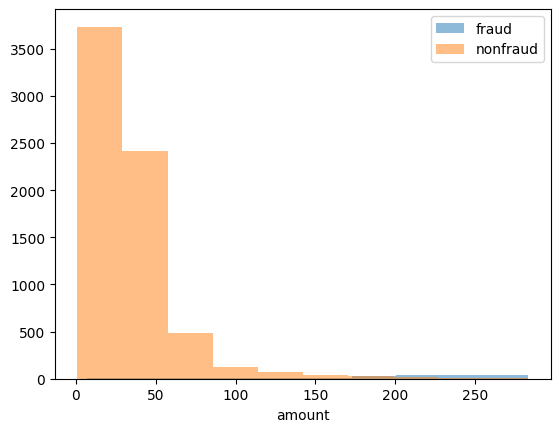

In [88]:
# Split our dataset into two dataframes containing fraud and non-fraud data respectively
df_fraud = bank_df[bank_df.fraud == 1]
df_non_fraud = bank_df[bank_df.fraud == 0]

# Plot histograms of the amounts in the fraud and non-fraud dataframes
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.xlabel('amount')
plt.legend()
plt.show()

It's hard to see combined into one histogram (due to the small number of fraudulent transactions), so let's plot them separately:

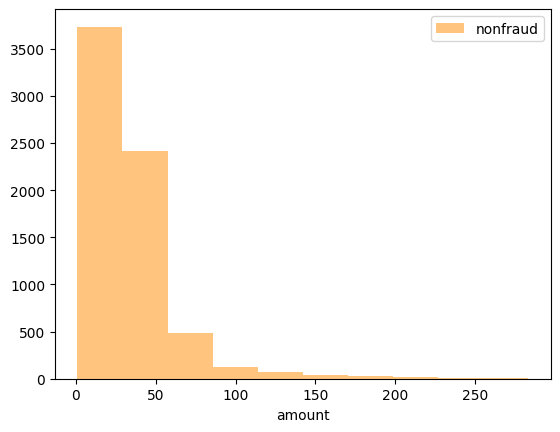

In [89]:
plt.hist(df_non_fraud.amount, color="darkorange", alpha=0.5, label='nonfraud')
plt.xlabel('amount')
plt.legend()
plt.show()

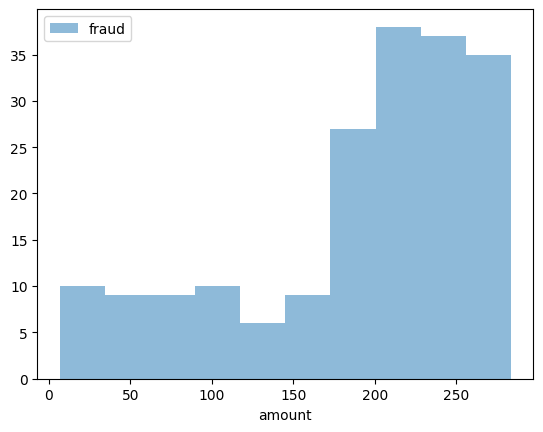

In [90]:
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')

plt.xlabel('amount')
plt.legend()
plt.show()

Now we can easily see that fraudulent transactions tend to be on the larger side when compared to most normal transactions.

## Using K-Means Clustering to Detect Fraud

<img src="https://raw.githubusercontent.com/iamamangosteen/aimlrpa/main/kmeansclustering.png">

Clustering algorithms detect trends in unlabelled datasets. More simply, they identify data points that are similar to one another. In doing so, you can often categorise your dataset. This is easy to visualise in two dimensions (as seen in the chart above), but once we have 10, 20, or even 100 variables, it's often too complex to easily visualise. Thus we rely on machine learning models to identify and extract our clusters for us.

The simplest clustering algorithm is **K-Means**. While simple and easy to understand, it often does not have the best performance. Later we'll take a look at an alternative, but more complex, clustering algorithm (DBSCAN) that often performs better.


With k-means, you need to specify how many clusters your dataset has. Of course, since this is unsupervised learning, we often don't know! So instead, we need to run k-means with different numbers of clusters and evaluate the performance of each run to see how many clusters our dataset has.

To do this, we can plot the number of clusters vs the resulting score of k-means. This type of plot is called an **Elbow Curve**. We identify the best number of clusters by looking for the "elbow" in the plot.

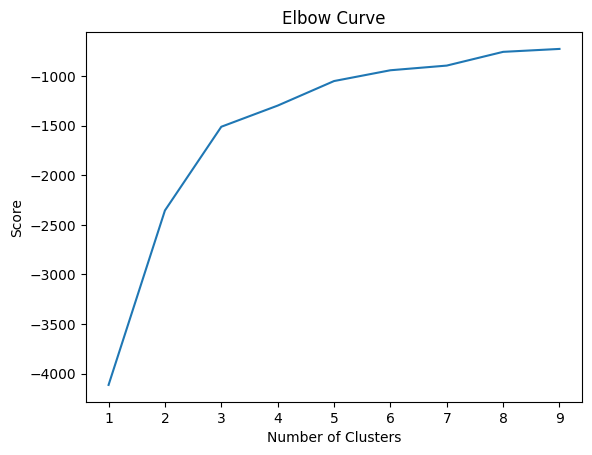

In [110]:
cols = ['age_bracket', 'amount', 'gender', 'restaurants', 'fashion',
        'food', 'health', 'home', 'hotels', 'leisure', 'other', 'sports',
        'tech', 'transport', 'travel']

cluster_df = bank_df[bank_df.age_bracket != 'U']

# Take the float values of df for X
X = cluster_df[cols].values.astype(np.float)

# Apply the scaler to the data
X_scaled = MinMaxScaler().fit_transform(X)

# Define the model
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
kmeans.fit(X_scaled)

# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

plt.plot(clust,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Here we can see that the "elbow" occurs at 3 clusters, meaning using 3 clusters is likely ideal. Fewer clusters will not capture all clusters in the data, and more clusters risks overfitting clusters. We'll use this number of clusters going forward!

## Assigning fraud vs. non-fraud

In order to identify likely fraud cases, we need to look at each cluster separately, and identify the outliers of that cluster. Doing so will give us a list of all abnormal transactions, which is a good starting point for checking for fraudulent transactions.

<img src="https://raw.githubusercontent.com/iamamangosteen/aimlrpa/main/kmeansclustering2.jpg">
<img src="https://raw.githubusercontent.com/iamamangosteen/aimlrpa/main/kmeansclustering3.jpg">

We can do this via python:

In [117]:
#Store the fraud labels for later evaluation
labels = cluster_df.fraud

# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.3, random_state=0)

# Define K-means model
kmeans = MiniBatchKMeans(n_clusters=3, random_state=0).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters
# This assumes all datapoints above the 95th percentile as outliers. Changing the number below will modify this.
cutoff = 95
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, cutoff)] = 1
km_y_pred[dist < np.percentile(dist, cutoff)] = 0

Confusion matrix, without normalization


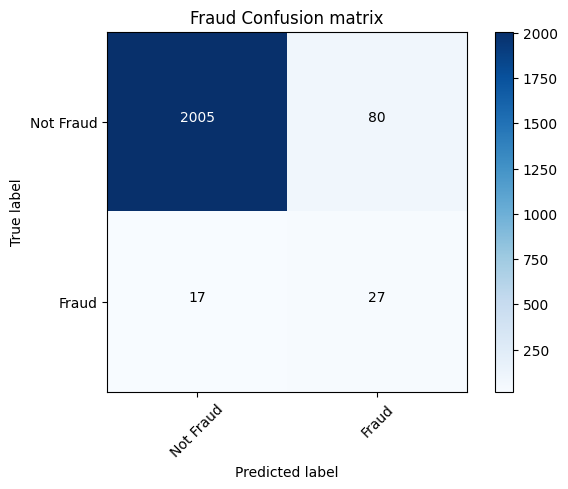

In [118]:
from itertools import product

def plot_confusion_matrix(cm, classes=['Not Fraud', 'Fraud'],
                          normalize=False,
                          title='Fraud Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-
        examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Obtain the ROC score
roc_auc_score(y_test, km_y_pred)

# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results
plot_confusion_matrix(km_cm)

We can also easily modify the outlier cutoff percentile to adjust the model. Below, we change the cutoff to the 93rd percentile. You can see that the number of cases of fraud caught increases. But at the tradeoff of more false positives.

Confusion matrix, without normalization


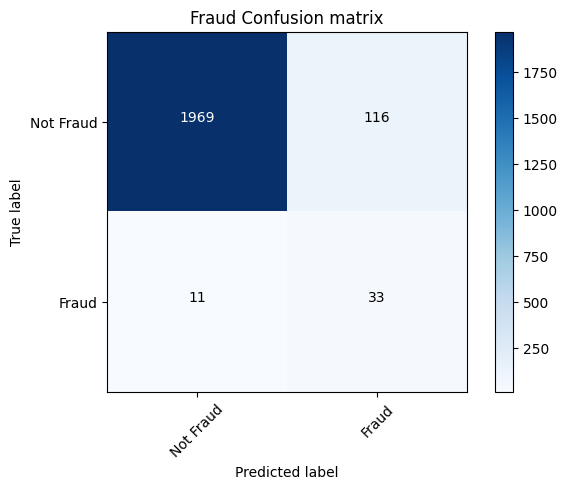

In [119]:
cutoff = 93
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, cutoff)] = 1
km_y_pred[dist < np.percentile(dist, cutoff)] = 0

# Obtain the ROC score
roc_auc_score(y_test, km_y_pred)

# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results
plot_confusion_matrix(km_cm)

## Using DBSCAN to Detect Fraud

As mentioned before, there are many different clustering methods which can be used for fraud detection. You can the different methods and their corresponding performance below. Each row represents a different dataset while each column represents a different clustering algorithm. The colours indicate the different clusters identified by the algorithm.

<img src="https://raw.githubusercontent.com/iamamangosteen/aimlrpa/main/clustering_methods.jpg">

We'll take a look at the DBSCAN algorithm next. DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. In contrast to K-Means, DBSCAN does not require you to specify the number of clusters - it will calculate the ideal number automatically! It also handles unusual datasets much better than k-means. However, the tradeoff is that it is much more computationally taxing.

Let's try and implement this in python:

In [120]:
# Initialize and fit the DBscan model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled)

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)

# Print performance metrics for DBscan
print(f'Estimated number of clusters: {n_clusters}')
print(f'Homogeneity: {homogeneity_score(labels, pred_labels):0.3f}')
print(f'Silhouette Coefficient: {silhouette_score(X_scaled, pred_labels):0.3f}')

Estimated number of clusters: 21
Homogeneity: 0.642
Silhouette Coefficient: 0.724


You'll notice that the number of clusters is much higher than k-means. DBSCAN works a bit differently: it will typically identify many more, smaller clusters. In order to identify unusual transactions, we look at the smallest clusters (by number of transactions) identified by DBSCAN.

In [123]:
# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels >= 0])

# Print the result
print("Number of transactions by cluster:")
for i in counts:
    print(i)

Number of transactions by cluster:
3249
144
2717
173
120
122
99
54
15
76
15
43
51
47
42
15
25
20
19
10


In [124]:
# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]
print(f'The smallest clusters are clusters: {smallest_clusters}')

# Print the counts of the smallest clusters only
print(f'Their counts are: {counts[smallest_clusters]}')

The smallest clusters are clusters: [19 15  8]
Their counts are: [10 15 15]


These clusters contain all the transactions that we would like to flag for further review. Once again, you can look at more than just the 3 smallest clusters: this would likely catch more cases of fraud, but also result in more false positives, thus increasing the workload of the human reviewers. We can view the results of this prediction:

In [126]:
# Create a dataframe of the predicted cluster numbers and fraud labels
df = pd.DataFrame({'clusternr':pred_labels,'fraud':labels})

# Create a condition flagging fraud for the smallest clusters
df['predicted_fraud'] = np.where((df['clusternr'].isin([19, 15, 8])), 1 , 0)

# Run a crosstab on the results
print(pd.crosstab(df['fraud'], df['predicted_fraud'], rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud     0   1
Actual Fraud           
0              6890  16
1               166  24


You'll notice in comparison with k-means, we have many fewer false positives, but also many more false negatives. Once again, we can try taking a different number of the smallest clusters (e.g. the 5 smallest, or the 7 smallest) to adjust these results depending on what metric we want to optimise.

<hr>

<hr>

<hr>

# Closing Thoughts

This notebook has explored some of the tools and knowledge needed to analyse, identify, and combat fraudulent behavior. We began by understanding the importance of data preparation and familiarizing ourselves with the intricacies of the dataset. Through techniques like data resampling and the Synthetic Minority Oversampling Technique (SMOTE), we have seen some of the skills necessary to tackle imbalanced data challenges head-on. After exploring the traditional methods of fraud detection, we witnessed the power of machine learning, employing techniques such as logistic regression and random forests to attempt to identify fraudulent activities. We also delved into the realm of unsupervised learning, where we discovered the potential of clustering algorithms such as K-Means Clustering and DBSCAN.

As we conclude this notebook, let us reflect that there are still many techniques and applications that we have not explored, such as text mining financial statements for fraud detection, or using etwork analysis to detect fraud. Hopefully you now have an appreciation for what is possible when using machine learning algorithms in Python. The world of machine learning awaits our contributions, and armed with Python and a solid understanding of its models, we are poised to shape the future!